In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

### EDA

In [30]:
df = pd.read_csv('housing.csv')

<Axes: xlabel='median_house_value', ylabel='Count'>

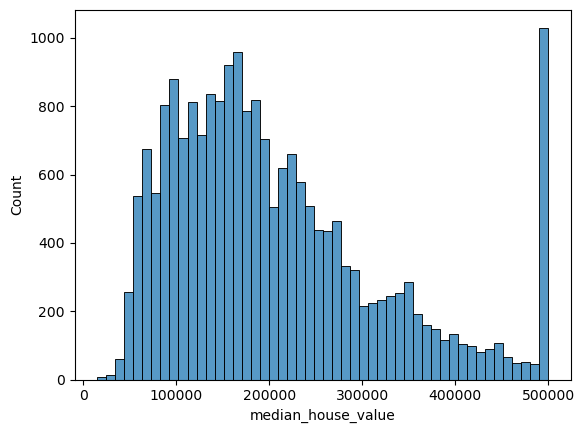

In [31]:
sns.histplot(df.median_house_value, bins=50)

### Preparing the dataset

In [32]:
df = df[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')]

In [33]:
features = ['latitude',
            'longitude',
            'housing_median_age',
            'total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'median_income',
            'median_house_value']

In [34]:
df = df[features]

In [35]:
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


### Question 1: There's one feature with missing values. What is it?

In [36]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2: What's the median (50% percentile) for variable 'population'?

In [37]:
df.population.describe()

count    15687.000000
mean      1466.317205
std       1180.389908
min          3.000000
25%        802.000000
50%       1195.000000
75%       1777.000000
max      35682.000000
Name: population, dtype: float64

### Prepare and split the dataset
Shuffle the dataset (the filtered one you created above), use seed 42.

Split your data in train/val/test sets, with 60%/20%/20% distribution.

Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [38]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
print(f"n_train: {n_train}, n_val: {n_val}, n_test: {n_test}")

n_train: 9413, n_val: 3137, n_test: 3137


In [39]:
df['median_house_value'] = np.log1p(df['median_house_value'])
data_train = df.iloc[idx[:n_train]]
data_val = df.iloc[idx[n_train:n_train+n_val]]
data_test = df.iloc[idx[n_train+n_val:]]

data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [40]:
y_train = data_train.median_house_value.values
y_val = data_val.median_house_value.values
y_test = data_test.median_house_value.values

In [41]:
del data_train['median_house_value']
del data_val['median_house_value']
del data_test['median_house_value']

<Axes: ylabel='Count'>

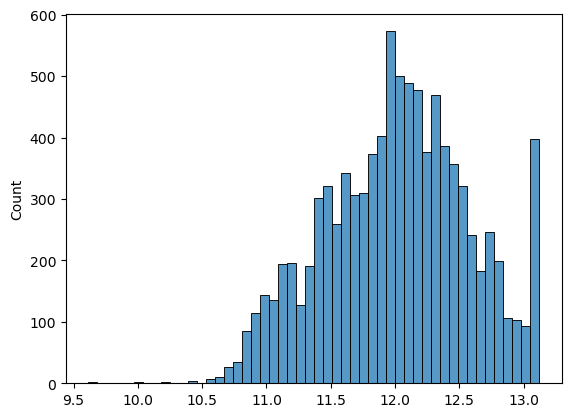

In [42]:
sns.histplot(y_train, bins=50)

### Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good

In [47]:
total_bedrooms_mean_value = data_train.total_bedrooms.mean()

In [48]:
def prepare_data(df, replace_value=None):
    df_temp = df.copy()
    if replace_value is None:
        X = df_temp.values
    else:
        df_temp['total_bedrooms'] = df_temp['total_bedrooms'].fillna(replace_value)
        X = df_temp.values
    return X
    
prepare_data(data_train, total_bedrooms_mean_value)

array([[ 3.6230e+01, -1.1914e+02,  2.2000e+01, ...,  1.9270e+03,
         5.3000e+02,  2.5875e+00],
       [ 3.4120e+01, -1.1779e+02,  1.6000e+01, ...,  1.3190e+03,
         4.4600e+02,  4.8125e+00],
       [ 3.3680e+01, -1.1797e+02,  2.6000e+01, ...,  1.9300e+03,
         5.8500e+02,  5.7301e+00],
       ...,
       [ 3.4130e+01, -1.1808e+02,  4.6000e+01, ...,  3.7700e+02,
         1.4500e+02,  8.4546e+00],
       [ 3.4290e+01, -1.1846e+02,  2.4000e+01, ...,  3.1510e+03,
         8.1000e+02,  3.0526e+00],
       [ 3.4000e+01, -1.1841e+02,  1.8000e+01, ...,  8.8400e+02,
         4.5600e+02,  2.9338e+00]])

In [49]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

#### Options
- With 0

In [52]:
X_train = prepare_data(data_train, 0)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_data(data_val, 0)
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred), 2)

0.34

- With mean

In [53]:
X_train = prepare_data(data_train, total_bedrooms_mean_value)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_data(data_val, total_bedrooms_mean_value)
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred), 2)

0.34

### Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?
- If there are multiple options, select the smallest r.

Options:

- 0
- 0.000001
- 0.001
- 0.0001

In [54]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train = data_train.fillna(0).values
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = data_val.fillna(0).values
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred).round(2)
    
    print(r, w0, score)

0 -9.763249477638553 0.34
1e-06 -9.76322883076761 0.34
0.0001 -9.761185235494285 0.34
0.001 -9.742646249238595 0.34
0.01 -9.56105619262636 0.34
0.1 -8.05888976905374 0.34
1 -3.1331542783425084 0.34
5 -0.8410867975245594 0.35
10 -0.4381172315887051 0.35


### Question 5
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

What's the value of std?
- 0.5
- 0.05
- 0.005
- 0.0005

Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [62]:
scores = []

n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
idx = np.arange(n)

for seed in range(10):
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.median_house_value.values
    y_val = df_val.median_house_value.values
    y_test = df_test.median_house_value.values

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    X_train = prepare_data(df_train, 0)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_data(df_val, 0)
    y_pred = w0 + X_val.dot(w)
    scores.append(rmse(y_val, y_pred))
    
print(np.std(scores).round(3))

0.006


### Question 6
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

Options:
- 0.13
- 0.23
- 0.33
- 0.43

In [64]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

data_train = df.iloc[idx[:n_train]]
data_val = df.iloc[idx[n_train:n_train+n_val]]
data_test = df.iloc[idx[n_train+n_val:]]

data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

y_train = data_train.median_house_value.values
y_val = data_val.median_house_value.values
y_test = data_test.median_house_value.values

del data_train['median_house_value']
del data_val['median_house_value']
del data_test['median_house_value']

data_full_train = pd.concat([data_train, data_val])
data_full_train = data_full_train.fillna(0).values
y_full_train = np.concatenate([y_train, y_val])

w0, w = train_linear_regression_reg(data_full_train, y_full_train, r=0.001)

data_test = data_test.fillna(0).values
y_pred = w0 + data_test.dot(w)
rmse(y_test, y_pred).round(2)

0.33